This notebook is heavily based on [this tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning)

# Detecting Frenchies with pretrained ConvNet

## DISCLAIMER
> This notebook is used for presentation and hence the specified problem is extermally oversimplified. This is to present technique and the code itself. The original model was trained on ImageNet dataset and then we transfer knowledge to detect french bulldogs. Data for the target task comes from Stanford Dog Breed dataset which itself is a subset of ImageNet. Beautiful Frenchie that is used as the example input at the end is Gacek, author's own dog.

This notebook contains simple presentation of basic approach to transfer learning in visual domain.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.


In this notebook, you will try one way to customize a pretrained model:

 - Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

## Few initial imports


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
#if you are running this on MacOS, uncomment line below:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

keras = tf.keras

## Data preprocessing

### Data download

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the stanford dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [8]:

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)



The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

In [15]:
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import img_to_array
import random
import string

def randomString(stringLength=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength)) + ".jpg"

get_label_name = metadata.features['label'].int2str
cnt = 0
for image, label in raw_train:
    if label == 0:
        cnt = cnt + 1
        if cnt == 300:
            break
        img_arr = img_to_array(image)
        save_image = save_img("./data/validation/frenchie/" + randomString(), img_arr)
        
#         plt.figure()
#         plt.imshow(image)
#         plt.title(get_label_name(label))
cnt

300

In [23]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'stanford_dogs',
    split=['train', 'test[:50%]', 'test[50%:]'],
    with_info=True,
    as_supervised=True,
)



In [50]:
from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import img_to_array
import random
import string

def randomString(stringLength=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength)) + ".jpg"

for image, label in raw_train.shuffle(1000):
    if label == 94:
        img_arr = img_to_array(image)
        save_image = save_img("./data/train/frenchie/" + randomString(), img_arr)
    elif label == 44:
        pass
    else
        img_arr = img_to_array(image)
        save_image = save_img("./data/train/other/" + randomString(), img_arr)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rescale=1./255.,
            featurewise_center=False,
            featurewise_std_normalization=False,
#             rotation_range=30,
#             width_shift_range=0.1,
            fill_mode="nearest",
#             height_shift_range=0.1,
#             shear_range=0.25,
#             zoom_range=0.2,
            horizontal_flip=True
#             vertical_flip=True
    )

train_generator = datagen.flow_from_directory(
        'data/train',
        target_size=(160, 160),
        batch_size=44,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(160, 160),
        batch_size=52,
        class_mode='binary')

Found 381 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [115]:
def is_frenchie(image, label):
    return image, 0 if label == 94 else 1

def class_func(features, label):
    return label

train_resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=[0.01498220346, 1-0.01498220346], seed=42)


frenchie_train = raw_train.map(lambda x, y: is_frenchie(x, y)).apply(train_resampler).map(lambda extra_label, features_and_label: features_and_label)
frenchie_validation = raw_validation.map(lambda x, y: is_frenchie(x, y))
frenchie_test = raw_test.map(lambda x, y: is_frenchie(x, y))


The resulting `tf.data.Dataset` objects contain `(image, label)` pairs where the images have variable shape and 3 channels, and the label is a scalar.

In [116]:
print(frenchie_train)
print(frenchie_validation)
print(frenchie_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int32)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int32)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int32)>


In [117]:
datagen

Show the first two images and labels from the training set:

In [25]:
# labels = set()

# for image, label in raw_train:
#     labels.add((label.numpy(), metadata.features['label'].int2str(label)))

# from tensorflow.keras.preprocessing.image import array_to_img
get_label_name = lambda x: "frenchie" if x == 0 else "other"
# i = 0
# label = 0
# for image_batch, label_batch in train_generator:
#     for i in range(0, 10):
#       plt.figure()
#       plt.imshow(image_batch[i])
#       plt.title(get_label_name(label_batch[i]))
#     break

In [47]:
labels

{(0, 'n02085620-chihuahua'),
 (1, 'n02085782-japanese_spaniel'),
 (2, 'n02085936-maltese_dog'),
 (3, 'n02086079-pekinese'),
 (4, 'n02086240-shih-tzu'),
 (5, 'n02086646-blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-rhodesian_ridgeback'),
 (9, 'n02088094-afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-walker_hound'),
 (16, 'n02089973-english_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-irish_wolfhound'),
 (20, 'n02091032-italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-ibizan_hound'),
 (23, 'n02091467-norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-saluki'),
 (26, 'n02092002-scottish_deerhound'),
 (27, 'n02092339-weimaraner'),
 (28, 'n02093256-staffordshire_bullterrier'),
 (29, 'n02093428-american_staffordshire_terrier'),


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [18]:
IMG_SIZE = 160 # All images will be resized to 160x160
# Bulldog class - 94
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [19]:
train = frenchie_train.map(format_example)
validation = frenchie_validation.map(format_example)
# test = frenchie_test.map(format_example)

NameError: name 'frenchie_train' is not defined

Now shuffle and batch the data.

In [121]:
# size = 0
# size_bdg = 0
# for x, y in train.take(100000):
#     if y == 1:
#         size = size + 1
#     else:
#         size_bdg = size_bdg + 1
# print(size, size_bdg)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [122]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
# test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [5]:
for image_batch, label_batch in train_generator:
   break

image_batch.shape

(44, 160, 160, 3)

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [6]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [7]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(44, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [8]:
base_model.trainable = False

In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(44, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [11]:
prediction_layer = keras.layers.Dense(1,)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(44, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [12]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [15]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~96% accuracy.


In [16]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_generator, steps = 1)

1/1 [==============================] - 2s 2s/step - loss: 0.8158 - accuracy: 0.3846


In [17]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.38


In [18]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=21,
                    validation_data=validation_generator,
                    epochs=10)

# history = model.fit(train_batches,
#                     epochs=initial_epochs,
#                     validation_data=validation_batches, 
#                     class_weight={0: 1., 1: 1.})

Epoch 1/10
21/21 [==============================] - 122s 6s/step - loss: 0.8181 - accuracy: 0.4575 - val_loss: 0.7210 - val_accuracy: 0.4615
Epoch 2/10
21/21 [==============================] - 124s 6s/step - loss: 0.7259 - accuracy: 0.5257 - val_loss: 0.6792 - val_accuracy: 0.5192
Epoch 3/10
21/21 [==============================] - 120s 6s/step - loss: 0.6787 - accuracy: 0.5518 - val_loss: 0.6292 - val_accuracy: 0.5769
Epoch 4/10
21/21 [==============================] - 126s 6s/step - loss: 0.6358 - accuracy: 0.6029 - val_loss: 0.5922 - val_accuracy: 0.6154
Epoch 5/10
21/21 [==============================] - 119s 6s/step - loss: 0.5902 - accuracy: 0.6507 - val_loss: 0.5807 - val_accuracy: 0.6346
Epoch 6/10
21/21 [==============================] - 117s 6s/step - loss: 0.5607 - accuracy: 0.6767 - val_loss: 0.5409 - val_accuracy: 0.7115
Epoch 7/10
21/21 [==============================] - 119s 6s/step - loss: 0.5220 - accuracy: 0.7103 - val_loss: 0.5294 - val_accuracy: 0.7308
Epoch 8/10
21

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

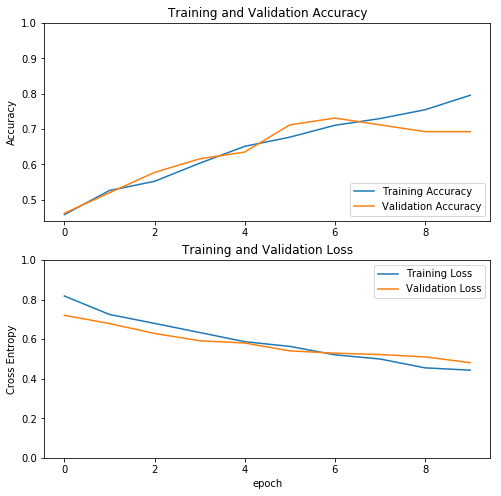

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Sample usage of the trained model

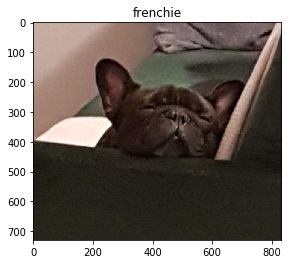

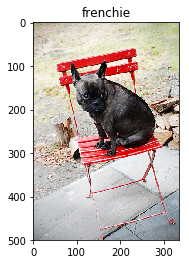

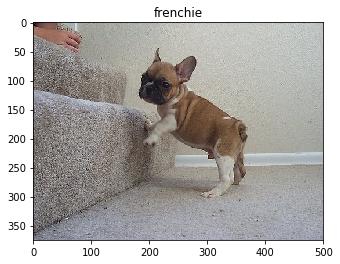

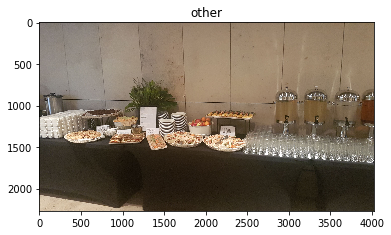

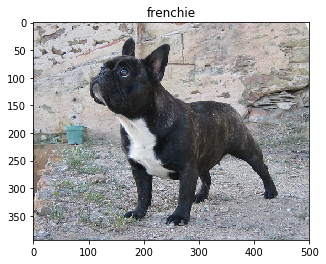

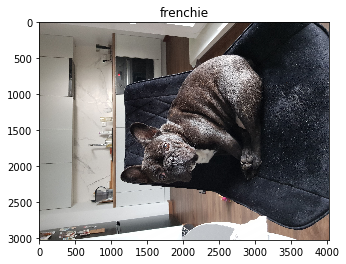

In [26]:
test_images = [keras.preprocessing.image.load_img('./test_images/' + filename) 
               for filename in os.listdir("./test_images") 
               if filename.endswith(".jpg")]

def to_model_ready_image(pil_image):
    image = tf.cast(keras.preprocessing.image.img_to_array(pil_image), tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

model_ready_images = [to_model_ready_image(test_image) for test_image in test_images]

for (test_image, model_ready_image) in zip(test_images, model_ready_images):
    plt.figure()
    plt.imshow(test_image)
    plt.title(get_label_name(model.predict_classes(np.expand_dims(model_ready_image, axis = 0))))


In [27]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(train_generator,
                         steps_per_epoch=20,      
                         epochs=20,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_generator)

Epoch 10/20
20/20 [==============================] - 125s 6s/step - loss: 0.3506 - accuracy: 0.8682 - val_loss: 0.4538 - val_accuracy: 0.7692
Epoch 11/20
20/20 [==============================] - 116s 6s/step - loss: 0.2475 - accuracy: 0.9212 - val_loss: 0.4468 - val_accuracy: 0.8077
Epoch 12/20
20/20 [==============================] - 224s 11s/step - loss: 0.1947 - accuracy: 0.9424 - val_loss: 0.4502 - val_accuracy: 0.8077
Epoch 13/20
20/20 [==============================] - 122s 6s/step - loss: 0.1479 - accuracy: 0.9665 - val_loss: 0.4446 - val_accuracy: 0.8269
Epoch 14/20
20/20 [==============================] - 130s 7s/step - loss: 0.1177 - accuracy: 0.9753 - val_loss: 0.4748 - val_accuracy: 0.8269
Epoch 15/20
20/20 [==============================] - 124s 6s/step - loss: 0.0865 - accuracy: 0.9859 - val_loss: 0.4850 - val_accuracy: 0.8269
Epoch 16/20
20/20 [==============================] - 120s 6s/step - loss: 0.0622 - accuracy: 0.9964 - val_loss: 0.4815 - val_accuracy: 0.8462
Epoch

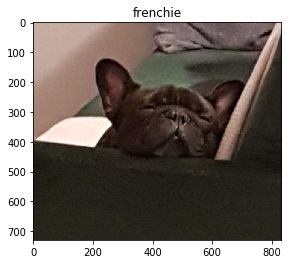

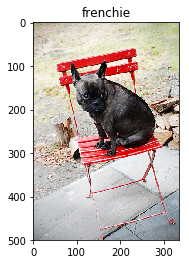

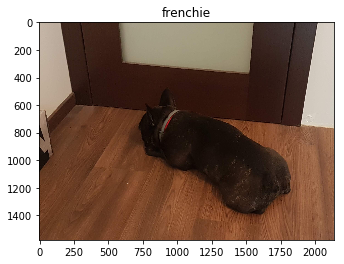

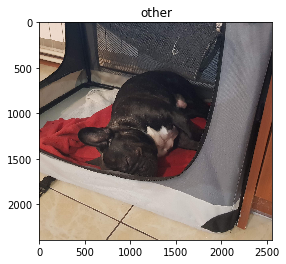

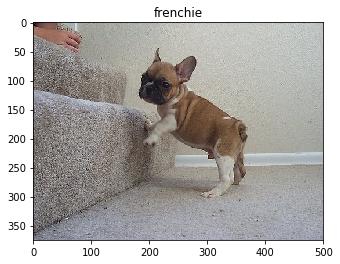

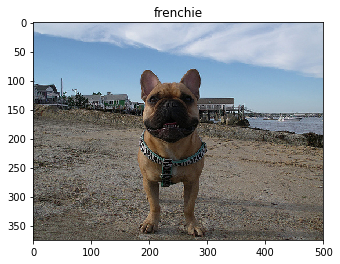

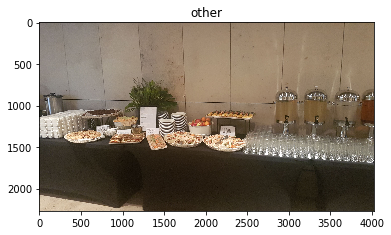

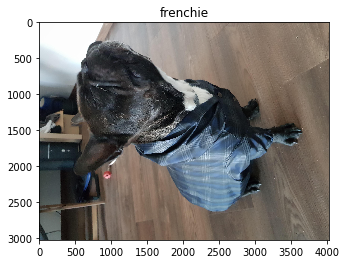

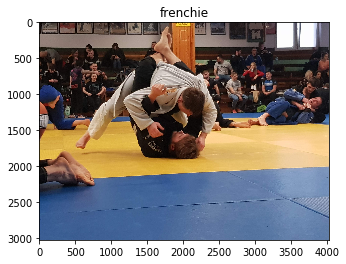

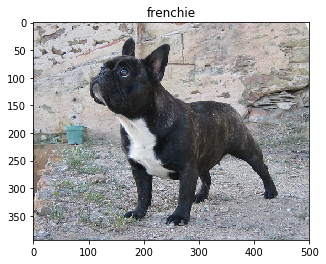

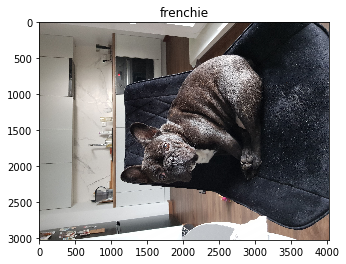

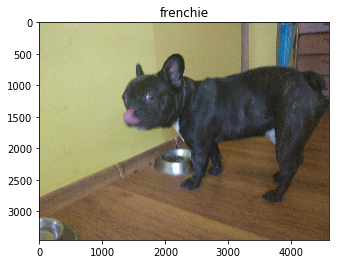

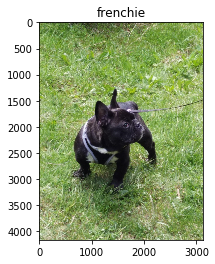

In [31]:
test_images = [keras.preprocessing.image.load_img('./test_images/' + filename) 
               for filename in os.listdir("./test_images") 
               if filename.endswith(".jpg")]

def to_model_ready_image(pil_image):
    image = tf.cast(keras.preprocessing.image.img_to_array(pil_image), tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

model_ready_images = [to_model_ready_image(test_image) for test_image in test_images]

for (test_image, model_ready_image) in zip(test_images, model_ready_images):
    plt.figure()
    plt.imshow(test_image)
    plt.title(get_label_name(model.predict_classes(np.expand_dims(model_ready_image, axis = 0))))